<a href="https://colab.research.google.com/github/ReAlex1902/NLP/blob/main/text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# While working through colab run next scripts to load data

In [ ]:
!pip install kaggle

In [ ]:
## upload your kaggle.json

from google.colab import files
files.upload()

{}

In [ ]:
# before importing the dataset we want to use this code
# The Kaggle API client expects this file to be in ~/.kaggle,
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d sohelranaccselab/lingspam-classification

  0% 0.00/3.12M [00:00<?, ?B/s]
100% 3.12M/3.12M [00:00<00:00, 103MB/s]


In [ ]:
# Downloading dataset:
from zipfile import ZipFile
import os
import pandas as pd

# # The below code is ran in google colab
# os.environ["KAGGLE_USERNAME"] = "KAGGLE_USERNAME"  # username from the json file
# os.environ["KAGGLE_KEY"] = "KAGGLE_KEY"  # key from the json file
# !kaggle datasets download -d praveengovi/coronahack-chest-xraydataset  # api copied from kaggle

# Create a ZipFile Object and load chest-xray-pneumonia.zip in it
with ZipFile("/content/lingspam-classification.zip", "r") as zipObj:
    # Extract all the contents of zip file in current directory
    zipObj.extractall()

# KAGGLE LINK: https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

### 1. Loading data

In [ ]:
# PATH = '../input/lingspam-classification/messages.csv' ## for kaggle
PATH = '/content/messages.csv' ## for colab
data = pd.read_csv(PATH)
data.head()

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


### 2. Data processing

In [ ]:
data = data.drop('subject', axis = 1)
data.head()

,message,label
0,content - length : 3386 apple-iss research cen...,0
1,"lang classification grimes , joseph e . and ba...",0
2,i am posting this inquiry for sergei atamas ( ...,0
3,a colleague and i are researching the differin...,0
4,earlier this morning i was on the phone with a...,0


In [ ]:
data['message'][0]

"content - length : 3386 apple-iss research center a us $ 10 million joint venture between apple computer inc . and the institute of systems science of the national university of singapore , located in singapore , is looking for : a senior speech scientist - - - - - - - - - - - - - - - - - - - - - - - - - the successful candidate will have research expertise in computational linguistics , including natural language processing and * * english * * and * * chinese * * statistical language modeling . knowledge of state-of - the-art corpus-based n - gram language models , cache language models , and part-of - speech language models are required . a text - to - speech project leader - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - the successful candidate will have research expertise expertise in two or more of the following areas : computational linguistics , including natural language parsing , lexical database design , and statistical language modeling ; text tokenization and

In [ ]:
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z.,!?]", " ", text)
    text = re.sub('\s+', ' ', text)
    return text

data['message'] = data['message'].apply(preprocess_text)
data.head()

,message,label
0,content length apple iss research center a us ...,0
1,"lang classification grimes , joseph e . and ba...",0
2,i am posting this inquiry for sergei atamas sa...,0
3,a colleague and i are researching the differin...,0
4,earlier this morning i was on the phone with a...,0


### 3. EDA

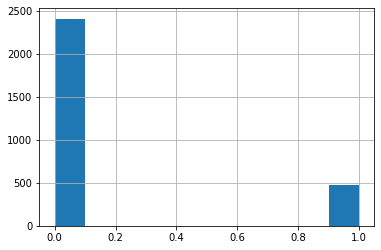

In [ ]:
data['label'].hist();

In [ ]:
data['label'].value_counts()

0    2412
1     481
Name: label, dtype: int64

In [ ]:
data['label'].value_counts()[0] / data['label'].value_counts().sum()

0.8337366055997235

##### Let's balance data using upsampling

In [ ]:
from sklearn.utils import resample

df_minority = data[data['label'] == 1].copy()
df_minority_upsampled = resample(df_minority, replace = True, 
                                 n_samples = data['label'].value_counts()[0], 
                                 random_state = 11)
df_minority_upsampled

,message,label
2491,the largest selection of hot beautiful xxx liv...,1
1151,", e mail addresses for only , please call abo...",1
482,the latest in adult technology ! ! ! brand new...,1
510,do n t want to receive these e mails ? click t...,1
2027,pardon the intrusion . no offence is meant . i...,1
...,...,...
2083,the rumors are true ! it s true ! you can make...,1
2447,xxxxxxxxxxxxxxxx credit control x x xxxxxxxxxx...,1
2683,net survey invites you to take our adult enter...,1
278,this is not spam ! my name is matthew . i mak...,1


In [ ]:
data = pd.concat([data[data['label'] == 0].copy(), df_minority_upsampled]).reset_index()
data

,index,message,label
0,0,content length apple iss research center a us ...,0
1,1,"lang classification grimes , joseph e . and ba...",0
2,2,i am posting this inquiry for sergei atamas sa...,0
3,3,a colleague and i are researching the differin...,0
4,4,earlier this morning i was on the phone with a...,0
...,...,...,...
4819,2083,the rumors are true ! it s true ! you can make...,1
4820,2447,xxxxxxxxxxxxxxxx credit control x x xxxxxxxxxx...,1
4821,2683,net survey invites you to take our adult enter...,1
4822,278,this is not spam ! my name is matthew . i mak...,1


In [ ]:
data['label'].value_counts()

1    2412
0    2412
Name: label, dtype: int64

### 4. Split data

In [ ]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(data, test_size = 0.2)
data_train, data_val = train_test_split(data_train, test_size = 0.15)

data_train = data_train.reset_index()
data_val = data_val.reset_index()
data_test = data_test.reset_index()

In [ ]:
data_train.shape, data_val.shape, data_test.shape

((3280, 4), (579, 4), (965, 4))

### 5. Creating dataset

In [ ]:
from torchtext.vocab import GloVe
embedding_glove = GloVe(name = '6B', dim = 100)

embedding_glove.stoi['<PAD>'] = len(embedding_glove.stoi)
embedding_glove.itos.append('<PAD>')

embedding_glove.stoi['<UNK>'] = len(embedding_glove.stoi)
embedding_glove.itos.append('<UNK>')

embedding_glove.vectors = torch.cat([embedding_glove.vectors, torch.zeros((2, embedding_glove.vectors[0].shape[0]))])

.vector_cache/glove.6B.zip: 862MB [02:56, 4.89MB/s]                           
100%|█████████▉| 399774/400000 [00:14<00:00, 27017.62it/s]

In [ ]:
class Config:
    sent_len = data_train['message'].str.split().str.len().max()
    batch_size = 128
    hidden_dim = 16
    gru_n_layers = 4

class SentenceDataset(Dataset):
    def __init__(self, data, vocab):
        super().__init__()
        self.X = data['message']
        self.y = data['label']
        self.vocab = vocab
        self.sent_len = Config.sent_len

    def vectorize(self, sent):

        sent = sent.split()
        sent_t = []
        for word in sent:
            try:
                sent_t.append(self.vocab.stoi[word])
            except:
                sent_t.append(self.vocab.stoi['<UNK>'])

        for _ in range(self.sent_len - len(sent)):
            sent_t.append(self.vocab.stoi['<PAD>'])

        return torch.tensor(sent_t)
  
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.vectorize(self.X[idx])[:self.sent_len], self.y[idx]
    
    
train_dataset = SentenceDataset(data_train, embedding_glove)
val_dataset = SentenceDataset(data_val, embedding_glove)
test_dataset = SentenceDataset(data_test, embedding_glove)
train_dataset[120]

(tensor([    59,      7,    229,  ..., 400000, 400000, 400000]), 0)

In [ ]:
train_dataset[120][0].shape, test_dataset[100][0].shape

(torch.Size([5249]), torch.Size([5249]))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = Config.batch_size)
val_loader = DataLoader(val_dataset, batch_size = Config.batch_size)
test_loader = DataLoader(test_dataset, batch_size = Config.batch_size)

In [ ]:
next(iter(train_loader))

[tensor([[   662,     84,    489,  ..., 400000, 400000, 400000],
         [   192,   1443,      2,  ..., 400000, 400000, 400000],
         [    58,   2089,      5,  ..., 400000, 400000, 400000],
         ...,
         [  5995, 400001,   9838,  ..., 400000, 400000, 400000],
         [ 68420,      3,    711,  ..., 400000, 400000, 400000],
         [    37,     14,     36,  ..., 400000, 400000, 400000]]),
 tensor([1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
         1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
         1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
         0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
         0, 0, 0, 1, 1, 0, 0, 1])]

### 6. Models

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler = None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0

        for i_step, (x, y) in enumerate(train_loader):
                
            optimizer.zero_grad()
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)
            loss_value = loss(prediction, y_gpu)
            loss_value.backward()
            optimizer.step()

            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        if scheduler:
            scheduler.step()
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        # if i_step % 10 == 1:
        print("Epoch: %i, Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (epoch, ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    right = 0
    total = 0
    for batch in loader:
        x, y = batch
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        preds = model(x_gpu)
        preds = torch.argmax(preds, axis = 1)
        right += torch.sum(preds == y_gpu)
        total += y_gpu.shape[0]
    return float(right) / total

In [ ]:
import sklearn.metrics as metrics

def evaluate_model(model, loader):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of booleans of model predictions
    grount_truth: np array of boolean of actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # loader = torch.utils.data.DataLoader(dataset, batch_size = Config.batch_size)
    ground_truth = np.array([])
    predictions = np.array([])

    for batch in loader:
        x, y = batch
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        ground_truth = np.append(ground_truth, y)
        prediction = model(x_gpu)
        _, prediction = torch.max(prediction, axis = 1)    ## torch.max() returns (values, indices)
        predictions = np.append(predictions, prediction.cpu())
    return predictions, ground_truth

def binary_classification_metrics(model, loader):
    prediction, ground_truth = evaluate_model(model, loader)
    precision = metrics.precision_score(prediction, ground_truth)
    recall = metrics.recall_score(prediction, ground_truth)
    f1 = (2 * precision * recall) / (precision + recall)
    acc = compute_accuracy(model, test_loader)
    return precision, recall, f1, acc

##### Vanilla Net

In [ ]:
class VanillaNet(nn.Module):
    def __init__(self, pretrained_embeddings = True):
        super().__init__()
        self.embedding = nn.Embedding(len(embedding_glove), 100)
        if pretrained_embeddings:
            self.embedding = self.embedding.from_pretrained(embedding_glove.vectors)
        
        self.net = nn.Sequential(
            self.embedding,
            nn.Flatten(),
            
            nn.Linear(Config.sent_len*100, 1024),
            nn.ReLU(inplace = True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace = True),
            nn.Linear(512, 128),
            nn.ReLU(inplace = True),
            nn.Linear(128, 2),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        input = self.net(input)
        return input

In [ ]:
## random embeddings

import torch.optim as optim

torch.cuda.empty_cache()

vanilla_net_random_embeddings = VanillaNet(pretrained_embeddings = False)
vanilla_net_random_embeddings.to(device)
parameters = vanilla_net_random_embeddings.parameters()

EPOCHS = 10

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(parameters, 1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 25)
loss_history, train_history, val_history = train_model(vanilla_net_random_embeddings, train_loader, val_loader,\
                                                       loss, optimizer, EPOCHS, scheduler)

 99%|█████████▉| 397458/400000 [00:29<00:00, 27551.44it/s]

Epoch: 0, Average loss: 0.730964, Train accuracy: 0.529268, Val accuracy: 0.499136
Epoch: 1, Average loss: 0.716682, Train accuracy: 0.526524, Val accuracy: 0.540587
Epoch: 2, Average loss: 0.850915, Train accuracy: 0.488720, Val accuracy: 0.540587
Epoch: 3, Average loss: 0.858285, Train accuracy: 0.489024, Val accuracy: 0.540587
Epoch: 4, Average loss: 0.858285, Train accuracy: 0.489024, Val accuracy: 0.540587
Epoch: 5, Average loss: 0.858285, Train accuracy: 0.489024, Val accuracy: 0.540587
Epoch: 6, Average loss: 0.858285, Train accuracy: 0.489024, Val accuracy: 0.540587
Epoch: 7, Average loss: 0.858285, Train accuracy: 0.489024, Val accuracy: 0.540587
Epoch: 8, Average loss: 0.858285, Train accuracy: 0.489024, Val accuracy: 0.540587
Epoch: 9, Average loss: 0.858285, Train accuracy: 0.489024, Val accuracy: 0.540587


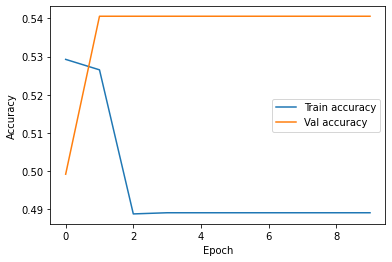

In [ ]:
ax = sns.lineplot(x = [i for i in range(EPOCHS)], y = train_history, label = 'Train accuracy');
ax = sns.lineplot(x = [i for i in range(EPOCHS)], y = val_history, label = 'Val accuracy');
ax.set(xlabel = 'Epoch', ylabel = 'Accuracy');

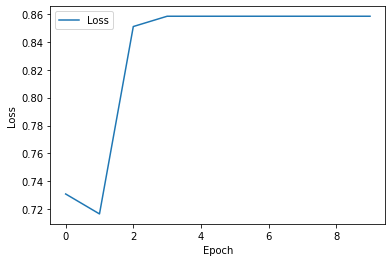

In [ ]:
ax = sns.lineplot(x = [i for i in range(EPOCHS)], y = loss_history, label = 'Loss');
ax.set(xlabel = 'Epoch', ylabel = 'Loss');

In [ ]:
precision, recall, f1, accuracy = binary_classification_metrics(vanilla_net_random_embeddings, test_loader)
print(f'Accuracy = {np.round(accuracy, 2)}')
print(f'Precision = {np.round(precision, 2)}')
print(f'Recall = {np.round(recall, 2)}')
print(f'F1 = {np.round(f1, 2)}')

Accuracy = 0.51
Precision = 1.0
Recall = 0.51
F1 = 0.68


In [ ]:
## pretrained embeddings

import torch.optim as optim

torch.cuda.empty_cache()

vanilla_net = VanillaNet(pretrained_embeddings = True)
vanilla_net.to(device)
parameters = vanilla_net.parameters()

EPOCHS = 10

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(parameters, 1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 25)
loss_history, train_history, val_history = train_model(vanilla_net, train_loader, val_loader,\
                                                       loss, optimizer, EPOCHS, scheduler)

Epoch: 0, Average loss: 0.517940, Train accuracy: 0.858537, Val accuracy: 0.975820
Epoch: 1, Average loss: 0.354439, Train accuracy: 0.986280, Val accuracy: 0.981002
Epoch: 2, Average loss: 0.334448, Train accuracy: 0.995427, Val accuracy: 0.974093
Epoch: 3, Average loss: 0.336380, Train accuracy: 0.992073, Val accuracy: 0.982729
Epoch: 4, Average loss: 0.331235, Train accuracy: 0.995732, Val accuracy: 0.996546
Epoch: 5, Average loss: 0.327598, Train accuracy: 0.999390, Val accuracy: 0.993092
Epoch: 6, Average loss: 0.327378, Train accuracy: 0.999085, Val accuracy: 0.993092
Epoch: 7, Average loss: 0.327212, Train accuracy: 0.999085, Val accuracy: 0.993092
Epoch: 8, Average loss: 0.327100, Train accuracy: 0.999085, Val accuracy: 0.994819
Epoch: 9, Average loss: 0.326717, Train accuracy: 0.999390, Val accuracy: 0.994819


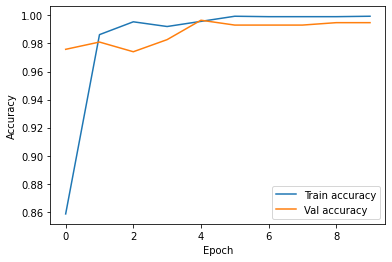

In [ ]:
ax = sns.lineplot(x = [i for i in range(EPOCHS)], y = train_history, label = 'Train accuracy');
ax = sns.lineplot(x = [i for i in range(EPOCHS)], y = val_history, label = 'Val accuracy');
ax.set(xlabel = 'Epoch', ylabel = 'Accuracy');

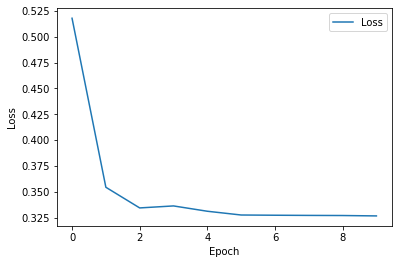

In [ ]:
ax = sns.lineplot(x = [i for i in range(EPOCHS)], y = loss_history, label = 'Loss');
ax.set(xlabel = 'Epoch', ylabel = 'Loss');

In [ ]:
## check on test dataset

precision, recall, f1, accuracy = binary_classification_metrics(vanilla_net, test_loader)
print(f'Accuracy = {np.round(accuracy, 2)}')
print(f'Precision = {np.round(precision, 2)}')
print(f'Recall = {np.round(recall, 2)}')
print(f'F1 = {np.round(f1, 2)}')

Accuracy = 0.99
Precision = 1.0
Recall = 0.99
F1 = 0.99


In [ ]:
# torch.save(vanilla_net.state_dict(), 'vanilla-net_1e-4_10-EPOCHS')

In [ ]:
torch.cuda.empty_cache()

##### Convolutional Net

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, pretrained_embeddings = True):
        super().__init__()
        self.embedding = nn.Embedding(len(embedding_glove), 100)  ## Config.sent_lenx100
        if pretrained_embeddings:
            self.embedding = self.embedding.from_pretrained(embedding_glove.vectors)
        
        self.layer1 = nn.Sequential(
            nn.Conv1d(Config.sent_len, 100, 11), ## 100x90
            nn.BatchNorm1d(100),
            nn.ReLU(inplace = True),
            nn.MaxPool1d(2)   ## 100x45
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv1d(100, 500, 10), ## 500x36
            nn.BatchNorm1d(500),
            nn.ReLU(inplace = True),
            nn.MaxPool1d(2)   ## 500x18
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv1d(500, 800, 5), ## 800x14
            nn.BatchNorm1d(800),
            nn.ReLU(inplace = True),
            nn.MaxPool1d(2)   ## 800x7
        )
        
        self.layer4 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(800*7, 512),
            nn.ReLU(inplace = True),
            
            nn.Linear(512, 128),
            nn.ReLU(inplace = True),
            
            nn.Linear(128, 2),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        input = self.embedding(input)
        input = self.layer1(input)
        input = self.layer2(input)
        input = self.layer3(input)
        input = self.layer4(input)
        return input

In [ ]:
## random embeddings

import torch.optim as optim

torch.cuda.empty_cache()

conv_net_random_embeddings = ConvNet(pretrained_embeddings = False)
conv_net_random_embeddings.to(device)
parameters = conv_net_random_embeddings.parameters()

EPOCHS = 10

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(parameters, 1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 25)
loss_history, train_history, val_history = train_model(conv_net_random_embeddings, train_loader, val_loader,\
                                                       loss, optimizer, EPOCHS, scheduler)

Epoch: 0, Average loss: 0.712946, Train accuracy: 0.541768, Val accuracy: 0.533679
Epoch: 1, Average loss: 0.676735, Train accuracy: 0.634756, Val accuracy: 0.670121
Epoch: 2, Average loss: 0.535989, Train accuracy: 0.807927, Val accuracy: 0.873921
Epoch: 3, Average loss: 0.440548, Train accuracy: 0.893293, Val accuracy: 0.614853
Epoch: 4, Average loss: 0.396786, Train accuracy: 0.933841, Val accuracy: 0.792746
Epoch: 5, Average loss: 0.362319, Train accuracy: 0.967683, Val accuracy: 0.772021
Epoch: 6, Average loss: 0.355866, Train accuracy: 0.973780, Val accuracy: 0.758204
Epoch: 7, Average loss: 0.351512, Train accuracy: 0.978963, Val accuracy: 0.715026
Epoch: 8, Average loss: 0.352463, Train accuracy: 0.979573, Val accuracy: 0.754750
Epoch: 9, Average loss: 0.342342, Train accuracy: 0.987805, Val accuracy: 0.939551


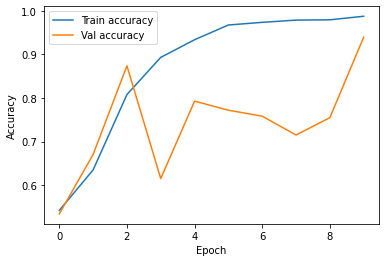

In [ ]:
ax = sns.lineplot(x = [i for i in range(EPOCHS)], y = train_history, label = 'Train accuracy');
ax = sns.lineplot(x = [i for i in range(EPOCHS)], y = val_history, label = 'Val accuracy');
ax.set(xlabel = 'Epoch', ylabel = 'Accuracy');

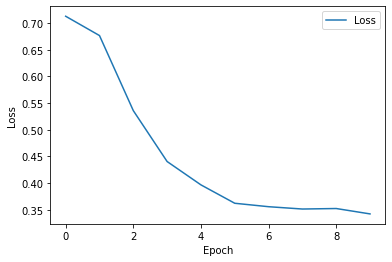

In [ ]:
ax = sns.lineplot(x = [i for i in range(EPOCHS)], y = loss_history, label = 'Loss');
ax.set(xlabel = 'Epoch', ylabel = 'Loss');

In [ ]:
## check on test dataset

precision, recall, f1, accuracy = binary_classification_metrics(conv_net_random_embeddings, test_loader)
print(f'Accuracy = {np.round(accuracy, 2)}')
print(f'Precision = {np.round(precision, 2)}')
print(f'Recall = {np.round(recall, 2)}')
print(f'F1 = {np.round(f1, 2)}')

Accuracy = 0.95
Precision = 0.99
Recall = 0.91
F1 = 0.95


In [ ]:
## pretrained embeddings

import torch.optim as optim

torch.cuda.empty_cache()

conv_net = ConvNet(pretrained_embeddings = True)
conv_net.to(device)
parameters = conv_net.parameters()

EPOCHS = 10

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(parameters, 1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 25)
loss_history, train_history, val_history = train_model(conv_net, train_loader, val_loader,\
                                                       loss, optimizer, EPOCHS, scheduler)

Epoch: 0, Average loss: 0.614269, Train accuracy: 0.721646, Val accuracy: 0.894646
Epoch: 1, Average loss: 0.376782, Train accuracy: 0.962500, Val accuracy: 0.972366
Epoch: 2, Average loss: 0.341557, Train accuracy: 0.988110, Val accuracy: 0.984456
Epoch: 3, Average loss: 0.333173, Train accuracy: 0.996341, Val accuracy: 0.982729
Epoch: 4, Average loss: 0.329714, Train accuracy: 0.997256, Val accuracy: 0.993092
Epoch: 5, Average loss: 0.326587, Train accuracy: 0.999390, Val accuracy: 0.991364
Epoch: 6, Average loss: 0.326162, Train accuracy: 0.999695, Val accuracy: 0.993092
Epoch: 7, Average loss: 0.325967, Train accuracy: 1.000000, Val accuracy: 0.993092
Epoch: 8, Average loss: 0.325903, Train accuracy: 1.000000, Val accuracy: 0.993092
Epoch: 9, Average loss: 0.325878, Train accuracy: 1.000000, Val accuracy: 0.993092


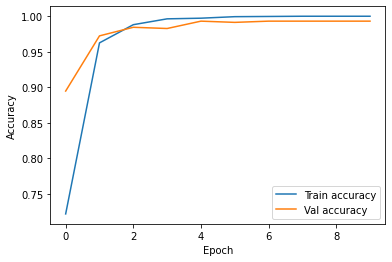

In [ ]:
ax = sns.lineplot(x = [i for i in range(EPOCHS)], y = train_history, label = 'Train accuracy');
ax = sns.lineplot(x = [i for i in range(EPOCHS)], y = val_history, label = 'Val accuracy');
ax.set(xlabel = 'Epoch', ylabel = 'Accuracy');

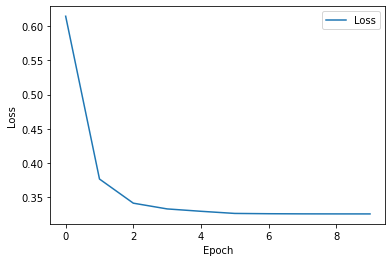

In [ ]:
ax = sns.lineplot(x = [i for i in range(EPOCHS)], y = loss_history, label = 'Loss');
ax.set(xlabel = 'Epoch', ylabel = 'Loss');

In [ ]:
## check on test dataset

precision, recall, f1, accuracy = binary_classification_metrics(conv_net, test_loader)
print(f'Accuracy = {np.round(accuracy, 2)}')
print(f'Precision = {np.round(precision, 2)}')
print(f'Recall = {np.round(recall, 2)}')
print(f'F1 = {np.round(f1, 2)}')

Accuracy = 0.99
Precision = 1.0
Recall = 0.99
F1 = 0.99


In [ ]:
# torch.save(conv_net.state_dict(), 'conv-net_1e-4_10-EPOCHS')

##### GRU Net

In [ ]:
class GRUNet(nn.Module):
    def __init__(self, pretrained_embeddings = True):
        super().__init__()
        self.embedding = nn.Embedding(len(embedding_glove), 100)  ## Config.sent_len x 100
        if pretrained_embeddings:
            self.embedding = self.embedding.from_pretrained(embedding_glove.vectors)
        
        self.gru = nn.GRU(100, Config.hidden_dim, Config.gru_n_layers, 
                          bidirectional = True, batch_first = True)
        
        self.layer = nn.Sequential(
            nn.Linear(2 * Config.hidden_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Sigmoid()
        )

    def forward(self, inp):
        inp = self.embedding(inp)
        inp, h = self.gru(inp)
        # concat the final output of forward direction and backward direction
        h = torch.cat((h[-2,:,:], h[-1,:,:]), dim = 1)
        out = self.layer(h)
        return out

In [ ]:
## random embeddings

import torch.optim as optim

torch.cuda.empty_cache()

gru_net_random_embeddings = GRUNet(pretrained_embeddings = False)
gru_net_random_embeddings.to(device)
parameters = gru_net_random_embeddings.parameters()

EPOCHS = 10

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(parameters, 1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 25)
loss_history, train_history, val_history = train_model(gru_net_random_embeddings, train_loader, val_loader,\
                                                       loss, optimizer, EPOCHS, scheduler)

Epoch: 0, Average loss: 0.664432, Train accuracy: 0.667683, Val accuracy: 0.863558
Epoch: 1, Average loss: 0.426839, Train accuracy: 0.905183, Val accuracy: 0.922280
Epoch: 2, Average loss: 0.373383, Train accuracy: 0.953354, Val accuracy: 0.941278
Epoch: 3, Average loss: 0.361447, Train accuracy: 0.963415, Val accuracy: 0.960276
Epoch: 4, Average loss: 0.349215, Train accuracy: 0.978049, Val accuracy: 0.968912
Epoch: 5, Average loss: 0.344894, Train accuracy: 0.981707, Val accuracy: 0.963731
Epoch: 6, Average loss: 0.344163, Train accuracy: 0.982012, Val accuracy: 0.965458
Epoch: 7, Average loss: 0.340512, Train accuracy: 0.985976, Val accuracy: 0.974093
Epoch: 8, Average loss: 0.340244, Train accuracy: 0.986280, Val accuracy: 0.974093
Epoch: 9, Average loss: 0.340236, Train accuracy: 0.986280, Val accuracy: 0.974093


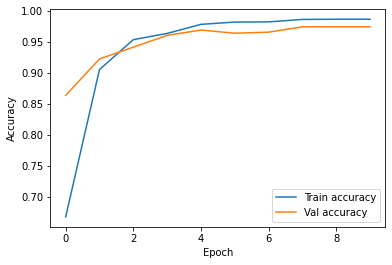

In [ ]:
ax = sns.lineplot(x = [i for i in range(EPOCHS)], y = train_history, label = 'Train accuracy');
ax = sns.lineplot(x = [i for i in range(EPOCHS)], y = val_history, label = 'Val accuracy');
ax.set(xlabel = 'Epoch', ylabel = 'Accuracy');

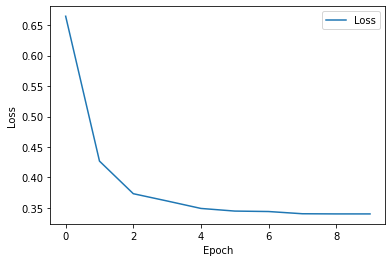

In [ ]:
ax = sns.lineplot(x = [i for i in range(EPOCHS)], y = loss_history, label = 'Loss');
ax.set(xlabel = 'Epoch', ylabel = 'Loss');

In [ ]:
## check on test dataset

precision, recall, f1, accuracy = binary_classification_metrics(gru_net_random_embeddings, test_loader)
print(f'Accuracy = {np.round(accuracy, 2)}')
print(f'Precision = {np.round(precision, 2)}')
print(f'Recall = {np.round(recall, 2)}')
print(f'F1 = {np.round(f1, 2)}')

Accuracy = 0.96
Precision = 0.97
Recall = 0.96
F1 = 0.97


In [ ]:
## pretrained embeddings

import torch.optim as optim

torch.cuda.empty_cache()

gru_net = GRUNet(pretrained_embeddings = True)
gru_net.to(device)
parameters = gru_net.parameters()

EPOCHS = 10

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(parameters, 1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 25)
loss_history, train_history, val_history = train_model(gru_net, train_loader, val_loader,\
                                                       loss, optimizer, EPOCHS, scheduler)

Epoch: 0, Average loss: 0.678693, Train accuracy: 0.682317, Val accuracy: 0.870466
Epoch: 1, Average loss: 0.415216, Train accuracy: 0.918598, Val accuracy: 0.943005
Epoch: 2, Average loss: 0.369966, Train accuracy: 0.956707, Val accuracy: 0.953368
Epoch: 3, Average loss: 0.363395, Train accuracy: 0.961585, Val accuracy: 0.974093
Epoch: 4, Average loss: 0.345116, Train accuracy: 0.980793, Val accuracy: 0.979275
Epoch: 5, Average loss: 0.348158, Train accuracy: 0.976829, Val accuracy: 0.948187
Epoch: 6, Average loss: 0.348104, Train accuracy: 0.977744, Val accuracy: 0.962003
Epoch: 7, Average loss: 0.342225, Train accuracy: 0.982927, Val accuracy: 0.991364
Epoch: 8, Average loss: 0.336930, Train accuracy: 0.988720, Val accuracy: 0.989637
Epoch: 9, Average loss: 0.335511, Train accuracy: 0.990549, Val accuracy: 0.987910


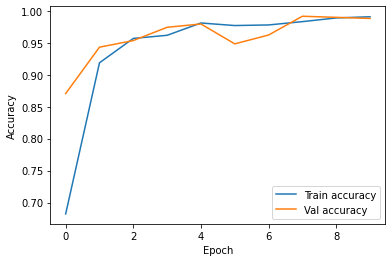

In [ ]:
ax = sns.lineplot(x = [i for i in range(EPOCHS)], y = train_history, label = 'Train accuracy');
ax = sns.lineplot(x = [i for i in range(EPOCHS)], y = val_history, label = 'Val accuracy');
ax.set(xlabel = 'Epoch', ylabel = 'Accuracy');

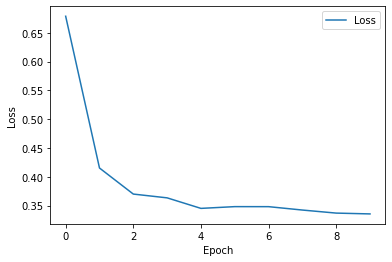

In [ ]:
ax = sns.lineplot(x = [i for i in range(EPOCHS)], y = loss_history, label = 'Loss');
ax.set(xlabel = 'Epoch', ylabel = 'Loss');

In [ ]:
## check on test dataset

precision, recall, f1, accuracy = binary_classification_metrics(gru_net, test_loader)
print(f'Accuracy = {np.round(accuracy, 2)}')
print(f'Precision = {np.round(precision, 2)}')
print(f'Recall = {np.round(recall, 2)}')
print(f'F1 = {np.round(f1, 2)}')

Accuracy = 0.99
Precision = 1.0
Recall = 0.97
F1 = 0.99


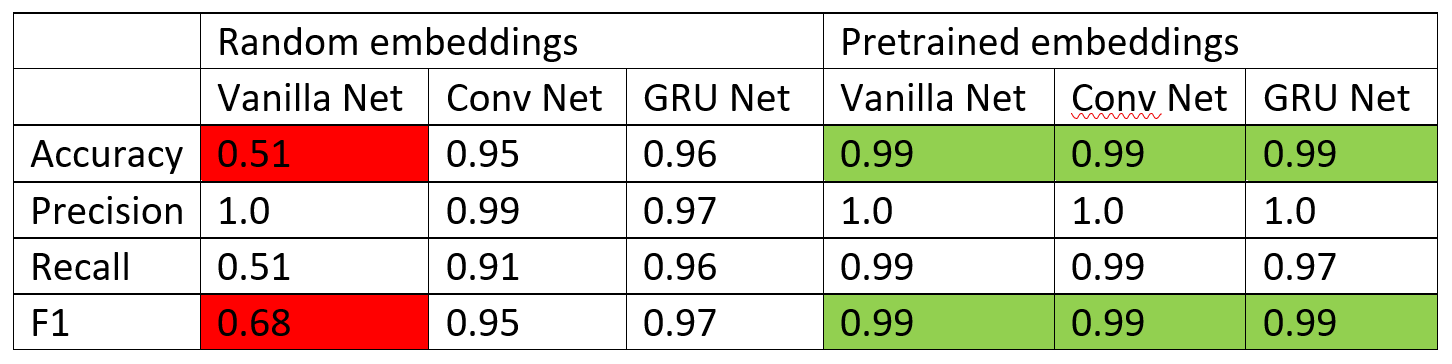